In [1]:
#This notebook is used to generate Figure 12 from Reichl et al. (2024)
# submitted to ESS

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import gsw as gsw
import matplotlib as mpl
from glob import glob
import pickle
import copy
Lat='0n'

In [ ]:
#Note that this cell processes the raw data, which is not archived.
# the output of this cell is archived.

Model=xr.Dataset()
pth = '/archive/bgr/MOM6/Experiments/OceanMixing/OM4_025.JRA/RS2000/'


for TAG,YRS,LBL in [['OM4_Zstr',[2001,2008],'OM4'],
                    ['OM4_ZStr_MStarCap1p25',[2001,2008],'OM4-ePBLcap'],
                    ['OM4_ZStr_KV0',[2001,2008],'OM4-KV0'],
                    ['OM4up_ZStr_KV0_MStarCap1p25',[2001,2008],'OM4up'],
                    ['OM4up_ZStr225_KV0_MStarCap1p25',[2001,2008],'OM4up 225'],
               ]:
    for i,Lon in enumerate(['165e','170w','140w','110w']):
    

        Zdir  = (pth+TAG)
        model_file=[]
        for Yr in range(YRS[0],YRS[1]+1):
            model_path=Zdir+'/'+str(Yr)+'/'
            print(model_path)
            model_file += [glob(model_path+str(Yr)+'0101.*'+Lat+Lon+'.nc.*')[0]]
        lst=''
        for element in model_file:
            lst+=' '+element
        print(lst)
        Hmod = (xr.open_mfdataset(model_file))

        U_Model = (Hmod.uo).values.squeeze()
        V_Model = (Hmod.vo).values.squeeze()
        #dU=smooth2d(U_Model)
        Z_Model = Hmod.zl.values
        #dU=np.gradient(dU/100.,Z_Model,axis=1)
        Sx_Model = (Hmod.uo.differentiate(coord='zl')**2).values.squeeze()
        Sy_Model = (Hmod.vo.differentiate(coord='zl')**2).values.squeeze()
        #Approximating N2 from the gradient of sigma_0
        Rho_Model = (Hmod.rhopot0).values.squeeze()
        N2_Model = (Hmod.rhopot0.differentiate(coord='zl')).values.squeeze()*9.81/1025
        Zi_Model = Hmod.zi.values
        Kd_Model = (Hmod.Kd_interface).values.squeeze()
        
        Model['Time_'+LBL+'_'+Lon] = Hmod.Time.values
        Model['Z_'+LBL+'_'+Lon] = Z_Model
        Model['U_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),U_Model)
        Model['V_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),V_Model)
        Model['Sx_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Sx_Model)
        Model['Sy_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Sy_Model)
        Model['N2_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),N2_Model)
        Model['Rho0_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Rho_Model)
        Model['Zi_'+LBL+'_'+Lon] = Zi_Model
        Model['Kd_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Zi_'+LBL+'_'+Lon),Kd_Model)
Model.to_netcdf('../Data/MOM6Buoy_Outputs.nc')

In [2]:
Model = xr.open_dataset('../Data/MOM6Buoy_Outputs.nc')

In [3]:
#Copied here from the Process_Argo_... notebook
# see that notebook for more details.
with open('../Data/TAO_0n_FilesLists_025.pickle', 'rb') as f:
    [FILENAME_LIST_165e,FILENAME_LIST_170w,FILENAME_LIST_155w,FILENAME_LIST_140w, 
     FILENAME_LIST_125w, FILENAME_LIST_110w, FILENAME_LIST_95w] = pickle.load(
        f)   

def GetProfiles(FILENAME_LIST):
    TTL = 0
    for ii in FILENAME_LIST:
        TTL+=len(ii[1])

    time=list(np.zeros(TTL))

    Z_2d=np.zeros([TTL,1500])+np.NaN
    T_2d=np.zeros([TTL,1500])+np.NaN
    dTdz_2d=np.zeros([TTL,1500])+np.NaN
    S_2d=np.zeros([TTL,1500])+np.NaN
    dSdz_2d=np.zeros([TTL,1500])+np.NaN
    N2_2d=np.zeros([TTL,1500])+np.NaN

    iii=-1
    for ii in FILENAME_LIST:
        with xr.open_dataset(ii[0]) as hndl:
            for p in ii[1]:
                iii+=1
                if (np.mod(iii,100)==0): print(1.*iii/TTL)
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)

                #Computes in-situ density from T&S, T, or S

                #Start with some quality control on the data
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                long=hndl.LONGITUDE[p].values
                lat=hndl.LATITUDE[p].values
                Pressure = hndl.PRES[p,:][LI].astype(np.float64)
                PSal = hndl.PSAL[p,:].values[LI].astype(np.float64)
                dP = Pressure[1]-Pressure[0]
                #PSal = smooth(PSal)
                ASal = gsw.SA_from_SP(PSal,Pressure,long,lat)
                Temp = hndl.TEMP[p,:].values[LI].astype(np.float64)
                #Temp = smooth(Temp)
                Rho = gsw.density.rho_t_exact(ASal,Temp,Pressure)
                
                
                
                CT = gsw.conversions.CT_from_rho(Rho,ASal,Pressure)[0]
                Rho0 = gsw.density.rho(ASal,CT,0)

                #Set a zero surface pressure bin
                P_i = np.array([0.]+list(Pressure))

                #First guess at Z_i from pressure
                Z_i = -1.*P_i
                dZ = (Z_i[:-1]-Z_i[1:])
                MULT = np.ones(np.size(dZ))
                MULT[Z_i[1:]<-200]=0
                if (np.nanmin(dZ)<=0 or 
                    np.nanmax(dZ*MULT)>=11 or #checking that upper 200 is 10m resolution
                    np.nanmax(dZ)>=60 or 
                    np.nanmin(Z_i)<-2100
                   ):
                    time[iii]=hndl.JULD[p].values

                else:
                    CT_i = np.array([CT[0]]+list(CT))
                    ASal_i = np.array([ASal[0]]+list(ASal))
                    Rho0_i = np.array([Rho0[0]]+list(Rho0))
                    Rho_i = np.array([Rho[0]]+list(Rho))
                    Pressure_i = np.array([0.,]+list(Pressure))
                    
                    
                    P_c       = 0.5*(P_i[1:]+P_i[:-1])
                    dP        = (P_i[:-1]-P_i[1:])
                    CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                    ASal_c    = 0.5*(ASal_i[1:]+ASal_i[:-1])
                    Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                    #Get density for layer from mean CT and Psal and central pressure
                    Rho = gsw.density.rho(ASal,CT_c,P_c)
                    #Compute Z_i referenced to a z=0 surface using layer mean density
                    # and assuming hydrostatic pressure
                    for zi in range(len(Rho)):
                        Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                    Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                    dZ = (Z_i[:-1]-Z_i[1:])
                    dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ
                    dCTdz_c = (CT_i[...,:-1]-CT_i[...,1:])/dZ
                    dSdz_c = (ASal_i[...,:-1]-ASal_i[...,1:])/dZ

                    #N2 needs to be computed from rho w/ central pressure.
                    Rho_i_Plo = gsw.density.rho_t_exact(ASal_i[1:],CT_i[1:],Pressure)
                    Rho_i_Pup = gsw.density.rho_t_exact(ASal_i[:-1],CT_i[:-1],Pressure)
                    N2_c = -9.81/1025*(Rho_i_Pup-Rho_i_Plo)/dZ
                    
                    LG = len(Z_c)
                    time[iii]=hndl.JULD[p].values

                    Z_2d[iii,:LG] = Z_c
                    dTdz_2d[iii,:LG] = dCTdz_c
                    T_2d[iii,:LG] = CT_c
                    dSdz_2d[iii,:LG] = dSdz_c
                    S_2d[iii,:LG] = ASal_c
                    N2_2d[iii,:LG] = N2_c
    return time,Z_2d,T_2d,dTdz_2d,S_2d,dSdz_2d,N2_2d



time_165e, Z_2d_165e,T_2d_165e,dTdz_2d_165e,S_2d_165e,dSdz_2d_165e,N2_2d_165e = GetProfiles(FILENAME_LIST_165e)
time_170w, Z_2d_170w,T_2d_170w,dTdz_2d_170w,S_2d_170w,dSdz_2d_170w,N2_2d_170w = GetProfiles(FILENAME_LIST_170w)
time_140w, Z_2d_140w,T_2d_140w,dTdz_2d_140w,S_2d_140w,dSdz_2d_140w,N2_2d_140w = GetProfiles(FILENAME_LIST_140w)
time_110w, Z_2d_110w,T_2d_110w,dTdz_2d_110w,S_2d_110w,dSdz_2d_110w,N2_2d_110w = GetProfiles(FILENAME_LIST_110w)

 
               

0.0
0.13869625520110956
0.27739251040221913
0.4160887656033287
0.5547850208044383
0.6934812760055479
0.8321775312066574
0.970873786407767
0.0
0.15267175572519084
0.3053435114503817
0.4580152671755725
0.6106870229007634
0.7633587786259542
0.916030534351145
0.0
0.13089005235602094
0.2617801047120419
0.39267015706806285
0.5235602094240838
0.6544502617801047
0.7853403141361257
0.9162303664921466
0.0
0.13227513227513227
0.26455026455026454
0.3968253968253968
0.5291005291005291
0.6613756613756614
0.7936507936507936
0.9259259259259259


In [4]:
def REGRID(Z_2d,T_2d,S_2d,DZ):
    REGRID_Zi = np.arange(0,-2000.1,-1*DZ)
    REGRID_Z = 0.5*(REGRID_Zi[1:]+REGRID_Zi[:-1])
    if DZ<0:
        REGRID_Z = -np.array([1.000000e+00, 3.000000e+00, 5.000000e+00, 7.000000e+00, 9.000000e+00,
           1.100000e+01, 1.300000e+01, 1.500000e+01, 1.700000e+01, 1.900000e+01,
           2.100000e+01, 2.300500e+01, 2.501500e+01, 2.703000e+01, 2.905500e+01,
           3.109000e+01, 3.314000e+01, 3.521000e+01, 3.731000e+01, 3.945000e+01,
           4.164000e+01, 4.390000e+01, 4.625000e+01, 4.871000e+01, 5.130500e+01,
           5.406500e+01, 5.703000e+01, 6.024500e+01, 6.376000e+01, 6.764000e+01,
           7.195000e+01, 7.677000e+01, 8.219500e+01, 8.832500e+01, 9.527500e+01,
           1.031800e+02, 1.121900e+02, 1.224700e+02, 1.342050e+02, 1.476000e+02,
           1.628900e+02, 1.803300e+02, 2.002000e+02, 2.228150e+02, 2.485150e+02,
           2.776750e+02, 3.107050e+02, 3.480550e+02, 3.902150e+02, 4.377200e+02,
           4.911500e+02, 5.511300e+02, 6.183450e+02, 6.935350e+02, 7.774950e+02,
           8.710850e+02, 9.752300e+02, 1.090920e+03, 1.219225e+03, 1.361290e+03,
           1.518340e+03, 1.691690e+03, 1.882745e+03, 2.093005e+03, 2.324070e+03,
           2.577645e+03, 2.855540e+03, 3.159680e+03, 3.492120e+03, 3.855035e+03,
           4.250730e+03, 4.681650e+03, 5.150385e+03, 5.659675e+03, 6.212405e+03])
        
    TTL=np.shape(Z_2d)[0]
    
    REGRID_T = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_S = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_dTdz = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_dSdz = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_N2 = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_RHO0 = np.zeros([TTL,len(REGRID_Z)])+np.NaN

    for ii in range(TTL):
        MASK = (np.isfinite(Z_2d[ii,::-1]))&(np.isfinite(T_2d[ii,::-1]))&(np.isfinite(S_2d[ii,::-1]))
        if np.sum(MASK)>10:
            REGRID_T[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1][MASK],T_2d[ii,::-1][MASK],left=np.NaN,right=np.NaN)
            REGRID_S[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1][MASK],S_2d[ii,::-1][MASK],left=np.NaN,right=np.NaN)
            rho0 = gsw.density.rho(REGRID_S[ii,:],REGRID_T[ii,:],0)
            REGRID_dTdz[ii,:] = np.gradient(REGRID_T[ii,:],REGRID_Z)
            REGRID_dSdz[ii,:] = np.gradient(REGRID_S[ii,:],REGRID_Z)
            REGRID_RHO0[ii,:] = gsw.density.rho(REGRID_S[ii,:],REGRID_T[ii,:],0)
            #N2 is approximated from the gradient of potential
            # temperature to make a fair comparison with model
            # data.
            #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
            #Argo measurements are usually preprocessed into
            #1db, 2db, or 4db vertical pressure spacing.
            #if it is 1db it is finer than the finest model
            # grid (2m) so for those cases
            # we smooth it with a 1:2:1 filter.
            # if (abs(Z_2d[ii,0]-Z_2d[ii,1])<0.8*DZ):
            #     #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
            #     rho0=smooth(rho0)
            REGRID_N2[ii,:] = -np.gradient(rho0,REGRID_Z)*9.81/1025.
            
    return REGRID_Z,REGRID_T,REGRID_S,REGRID_dTdz,REGRID_dSdz, REGRID_N2, REGRID_RHO0

#Setting <0 uses the OM4 z* grid
dz = -1
REGRID_Z,REGRID_T_165e, REGRID_S_165e, REGRID_dTdz_165e, REGRID_dSdz_165e, REGRID_N2_165e, REGRID_RHO_165e = REGRID(Z_2d_165e,T_2d_165e,S_2d_165e,dz)
REGRID_Z,REGRID_T_170w, REGRID_S_170w, REGRID_dTdz_170w, REGRID_dSdz_170w, REGRID_N2_170w, REGRID_RHO_170w = REGRID(Z_2d_170w,T_2d_170w,S_2d_170w,dz)
REGRID_Z,REGRID_T_140w, REGRID_S_140w, REGRID_dTdz_140w, REGRID_dSdz_140w, REGRID_N2_140w, REGRID_RHO_140w = REGRID(Z_2d_140w,T_2d_140w,S_2d_140w,dz)
REGRID_Z,REGRID_T_110w, REGRID_S_110w, REGRID_dTdz_110w, REGRID_dSdz_110w, REGRID_N2_110w, REGRID_RHO_110w = REGRID(Z_2d_110w,T_2d_110w,S_2d_110w,dz)

            

/net2/bgr/mamba/miniforge3/envs/om5/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/tmp/ipykernel_1326762/2656551687.py:98: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(U,axis=0)
/tmp/ipykernel_1326762/2656551687.py:144: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(dU**2,axis=0)
/tmp/ipykernel_1326762/2656551687.py:191: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(rho,axis=0)
/tmp/ipykernel_1326762/2656551687.py:236: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(N2,axis=0)
/tmp/ipykernel_1326762/2656551687.py:239: RuntimeWarning: invalid value encountered in log10
  a.plot(np.log10(low),Za,'-',linewidth=0.5,color='k')
/tmp/ipykernel_1326762/2656551687.py:241: RuntimeWarning: invalid value encountered in log10
  a.fill_betweenx(Za,np.log10(low),np.log10(high),color='k',alpha=0.2)
/tmp/ipykernel_1326762/2656551687.py:246: RuntimeWarning: divide by zero enc

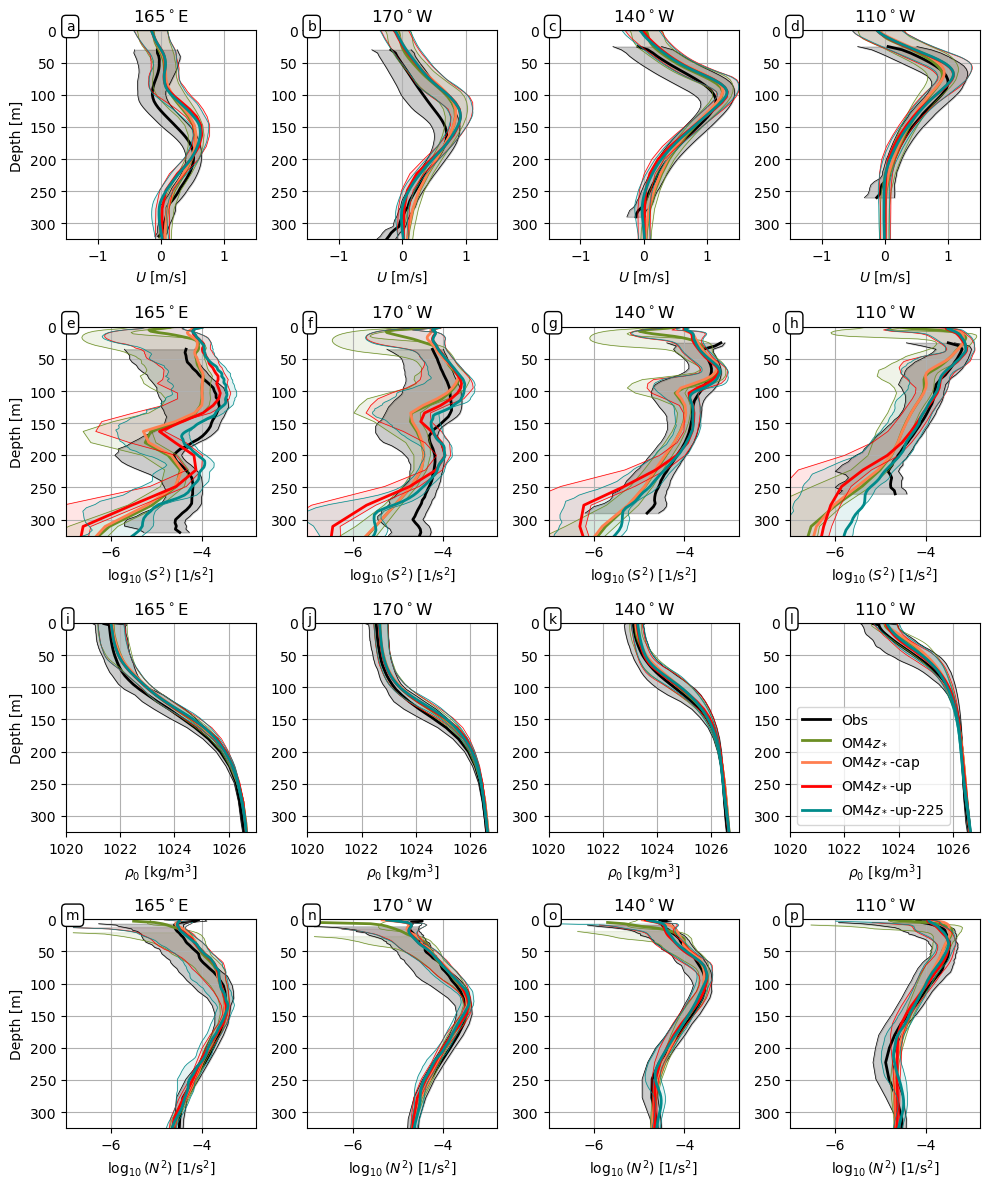

In [15]:

fig,AX=plt.subplots(4,4,figsize=(10,12))
colors1 = cmocean.cm.amp(np.linspace(0., 1, 128))
colors2 = cmocean.cm.amp_r(np.linspace(0, 1, 128))
# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('amp2amp_r', colors)
levels=np.linspace(0,1,21)

LBL = 'OM4up 225';
TTL = 'OM4$z_*$-up-225';
CL='darkcyan'

LBL1 = 'OM4-ePBLcap';
TTL1 = 'OM4$z_*$-cap';
CL1='coral';

LBL2 = 'OM4-KV0';
TTL2 = 'OM4$z_*$-KV0';
CL2='firebrick'

LBL3 = 'OM4'; 
TTL3 = 'OM4$z_*$';
CL3='olivedrab';

LBL4 = 'OM4up';
TTL4 = 'OM4$z_*$-up';
CL4='r';
    
for i,Lon in enumerate(['165e','170w','140w','110w']):
    
    #This block was used to create U utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'
    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    U= Hobs.u_1205.round(decimals=1).values.squeeze().astype(np.float64)/100.
    U[abs(U)>1.e3]=np.NaN
    Z=Hobs.depth.values.astype(np.float64)
    dU=np.gradient(U,Z,axis=1)
    dU[:,np.sum(np.isfinite(U),axis=0)<=1000]=np.NaN
    U[:,np.sum(np.isfinite(U),axis=0)<=1000]=np.NaN
    
    
    if Lon=='165e':
        N2 = REGRID_N2_165e
        rho = REGRID_RHO_165e
    elif Lon=='170w':
        N2 = REGRID_N2_170w
        rho = REGRID_RHO_170w
    elif Lon=='140w':
        N2 = REGRID_N2_140w
        rho = REGRID_RHO_140w
    elif Lon=='110w':
        N2 = REGRID_N2_110w
        rho = REGRID_RHO_110w

    COUNT = np.shape(N2)[0]

    
    Za = -REGRID_Z

    Um=Model['U_'+LBL+'_'+Lon]
    Rm=Model['Rho0_'+LBL+'_'+Lon]
    Sxm=Model['Sx_'+LBL+'_'+Lon]
    N2m=Model['N2_'+LBL+'_'+Lon]
    Zm=Model['Z_'+LBL+'_'+Lon]
    

    Um1=Model['U_'+LBL1+'_'+Lon]
    Rm1=Model['Rho0_'+LBL1+'_'+Lon]
    Sxm1=Model['Sx_'+LBL1+'_'+Lon]
    N2m1=Model['N2_'+LBL1+'_'+Lon]
    Zm1=Model['Z_'+LBL1+'_'+Lon]
    CT1 = Model['Time_'+LBL1+'_'+Lon]

    Um2=Model['U_'+LBL2+'_'+Lon]
    Rm2=Model['Rho0_'+LBL2+'_'+Lon]
    Sxm2=Model['Sx_'+LBL2+'_'+Lon]
    N2m2=Model['N2_'+LBL2+'_'+Lon]
    Zm2=Model['Z_'+LBL2+'_'+Lon]
    CT2 = Model['Time_'+LBL2+'_'+Lon]

    Um3=Model['U_'+LBL3+'_'+Lon]
    Rm3=Model['Rho0_'+LBL3+'_'+Lon]
    Sxm3=Model['Sx_'+LBL3+'_'+Lon]
    N2m3=Model['N2_'+LBL3+'_'+Lon]
    Zm3=Model['Z_'+LBL3+'_'+Lon]
    CT3 = Model['Time_'+LBL3+'_'+Lon]

    Um4=Model['U_'+LBL4+'_'+Lon]
    Rm4=Model['Rho0_'+LBL4+'_'+Lon]
    Sxm4=Model['Sx_'+LBL4+'_'+Lon]
    N2m4=Model['N2_'+LBL4+'_'+Lon]
    Zm4=Model['Z_'+LBL4+'_'+Lon]
    CT4 = Model['Time_'+LBL4+'_'+Lon]
    
    a=AX.ravel()[i]
    low = np.nanpercentile(U,20,axis=0)
    mean = np.nanmean(U,axis=0)
    high = np.nanpercentile(U,80,axis=0)
    a.plot((mean),Z,'-',linewidth=2,color='k')
    a.plot((low),Z,'-',linewidth=0.5,color='k')
    a.plot((high),Z,'-',linewidth=0.5,color='k')
    a.fill_betweenx(Z,(low),(high),color='k',alpha=0.2)
    
    low = np.nanpercentile(Um3.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Um3.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Um3.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm3,'-',linewidth=2,color=CL3)
    a.plot((low),Zm3,'-',linewidth=0.5,color=CL3)
    a.plot((high),Zm3,'-',linewidth=0.5,color=CL3)
    a.fill_betweenx(Zm3,(low),(high),color=CL3,alpha=0.1)
    
    mean = np.nanmean(Um1.values.astype(np.float64),axis=0)
    a.plot((mean),Zm1,'-',linewidth=2,color=CL1)
    
    low = np.nanpercentile(Um4.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Um4.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Um4.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm4,'-',linewidth=2,color=CL4)
    a.plot((low),Zm4,'-',linewidth=0.5,color=CL4)
    a.plot((high),Zm4,'-',linewidth=0.5,color=CL4)
    a.fill_betweenx(Zm4,(low),(high),color=CL4,alpha=0.1)

    low = np.nanpercentile(Um.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Um.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Um.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm,'-',linewidth=2,color=CL)
    a.plot((low),Zm,'-',linewidth=0.5,color=CL)
    a.plot((high),Zm,'-',linewidth=0.5,color=CL)
    a.fill_betweenx(Zm,(low),(high),color=CL,alpha=0.1)
    
    a.set_xlim(-1.5,1.5)
    a.set_ylim(325,0)
    a.set_title(Lon[:-1]+r'$^\circ$'+Lon[-1].upper())
    if i==0:
        a.set_ylabel('Depth [m]')
    
    a.set_xlabel('$U$ [m/s]')
    a.grid(True)

    
    a=AX.ravel()[i+4]
    low = np.nanpercentile(dU**2,20,axis=0)
    mean = np.nanmean(dU**2,axis=0)
    high = np.nanpercentile(dU**2,80,axis=0)
    a.plot(np.log10(mean),Z,'-',linewidth=2,color='k')
    a.plot(np.log10(low),Z,'-',linewidth=0.5,color='k')
    a.plot(np.log10(high),Z,'-',linewidth=0.5,color='k')
    a.fill_betweenx(Z,np.log10(low),np.log10(high),color='k',alpha=0.2)
    
    low = np.nanpercentile(Sxm3.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Sxm3.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Sxm3.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm3,'-',linewidth=2,color=CL3)
    a.plot(np.log10(low),Zm3,'-',linewidth=0.5,color=CL3)
    a.plot(np.log10(high),Zm3,'-',linewidth=0.5,color=CL3)
    a.fill_betweenx(Zm3,np.log10(low),np.log10(high),color=CL3,alpha=0.1)

    mean = np.nanmean(Sxm1.values.astype(np.float64),axis=0)
    a.plot(np.log10(mean),Zm1,'-',linewidth=2,color=CL1)
    
    
    low = np.nanpercentile(Sxm4.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Sxm4.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Sxm4.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm4,'-',linewidth=2,color=CL4)
    a.plot(np.log10(low),Zm4,'-',linewidth=0.5,color=CL4)
    a.plot(np.log10(high),Zm4,'-',linewidth=0.5,color=CL4)
    a.fill_betweenx(Zm4,np.log10(low),np.log10(high),color=CL4,alpha=0.1)
    
    low = np.nanpercentile(Sxm.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Sxm.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Sxm.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm,'-',linewidth=2,color=CL)
    a.plot(np.log10(low),Zm,'-',linewidth=0.5,color=CL)
    a.plot(np.log10(high),Zm,'-',linewidth=0.5,color=CL)
    a.fill_betweenx(Zm,np.log10(low),np.log10(high),color=CL,alpha=0.1)

    
    a.set_xlim(-7,-2.8)
    a.set_ylim(325,0)
    a.set_title(Lon[:-1]+r'$^\circ$'+Lon[-1].upper())
    if i==0:
        a.set_ylabel('Depth [m]')
    
    a.set_xlabel(r'$\log_{10}(S^2)$ [1/s$^2$]')
    a.grid(True)

    a=AX.ravel()[i+8]
    low = np.nanpercentile(rho,20,axis=0)
    mean = np.nanmean(rho,axis=0)
    high = np.nanpercentile(rho,80,axis=0)
    a.plot((mean),Za,'-',linewidth=2,color='k',label='Obs')
    a.plot((low),Za,'-',linewidth=0.5,color='k')
    a.plot((high),Za,'-',linewidth=0.5,color='k')
    a.fill_betweenx(Za,(low),(high),color='k',alpha=0.2)
    
    low = np.nanpercentile(Rm3.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Rm3.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Rm3.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm3,'-',linewidth=2,color=CL3,label=TTL3)
    a.plot((low),Zm3,'-',linewidth=0.5,color=CL3)
    a.plot((high),Zm3,'-',linewidth=0.5,color=CL3)
    
    mean = np.nanmean(Rm1.values.astype(np.float64),axis=0)
    a.plot((mean),Zm1,'-',linewidth=2,color=CL1,label=TTL1)

    low = np.nanpercentile(Rm4.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Rm4.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Rm4.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm4,'-',linewidth=2,color=CL4,label=TTL4)
    a.plot((low),Zm4,'-',linewidth=0.5,color=CL4)
    a.plot((high),Zm4,'-',linewidth=0.5,color=CL4)
    
    low = np.nanpercentile(Rm.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(Rm.values.astype(np.float64),axis=0)
    high = np.nanpercentile(Rm.values.astype(np.float64),80,axis=0)
    a.plot((mean),Zm,'-',linewidth=2,color=CL,label=TTL)
    a.plot((low),Zm,'-',linewidth=0.5,color=CL)
    a.plot((high),Zm,'-',linewidth=0.5,color=CL)
    a.fill_betweenx(Zm,(low),(high),color=CL,alpha=0.1)

    a.set_xlim(1020,1027)
    a.set_ylim(325,0)
    a.set_title(Lon[:-1]+r'$^\circ$'+Lon[-1].upper())
    if i==0:
        a.set_ylabel('Depth [m]')
    if i==3:
        a.legend()
    a.set_xlabel(r'$\rho_0$ [kg/m$^3$]')
    a.grid(True)

    
    a=AX.ravel()[i+12]
    low = np.nanpercentile(N2,20,axis=0)
    mean = np.nanmean(N2,axis=0)
    high = np.nanpercentile(N2,80,axis=0)
    a.plot(np.log10(mean),Za,'-',linewidth=2,color='k')
    a.plot(np.log10(low),Za,'-',linewidth=0.5,color='k')
    a.plot(np.log10(high),Za,'-',linewidth=0.5,color='k')
    a.fill_betweenx(Za,np.log10(low),np.log10(high),color='k',alpha=0.2)
    
    low = np.nanpercentile(N2m3.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(N2m3.values.astype(np.float64),axis=0)
    high = np.nanpercentile(N2m3.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm3,'-',linewidth=2,color=CL3)
    a.plot(np.log10(low),Zm3,'-',linewidth=0.5,color=CL3)
    a.plot(np.log10(high),Zm3,'-',linewidth=0.5,color=CL3)
    a.fill_betweenx(Zm3,np.log10(low),np.log10(high),color=CL3,alpha=0.1)

    mean = np.nanmean(N2m1.values.astype(np.float64),axis=0)
    a.plot(np.log10(mean),Zm1,'-',linewidth=2,color=CL1)

    
    low = np.nanpercentile(N2m4.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(N2m4.values.astype(np.float64),axis=0)
    high = np.nanpercentile(N2m4.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm4,'-',linewidth=2,color=CL4)
    a.plot(np.log10(low),Zm4,'-',linewidth=0.5,color=CL4)
    a.plot(np.log10(high),Zm4,'-',linewidth=0.5,color=CL4)
    a.fill_betweenx(Zm4,np.log10(low),np.log10(high),color=CL4,alpha=0.1)
    
    low = np.nanpercentile(N2m.values.astype(np.float64),20,axis=0)
    mean = np.nanmean(N2m.values.astype(np.float64),axis=0)
    high = np.nanpercentile(N2m.values.astype(np.float64),80,axis=0)
    a.plot(np.log10(mean),Zm,'-',linewidth=2,color=CL)
    a.plot(np.log10(low),Zm,'-',linewidth=0.5,color=CL)
    a.plot(np.log10(high),Zm,'-',linewidth=0.5,color=CL)
    a.fill_betweenx(Zm,np.log10(low),np.log10(high),color=CL,alpha=0.1)
    
    a.set_xlim(-7,-2.8)
    a.set_ylim(325,0)
    a.set_title(Lon[:-1]+r'$^\circ$'+Lon[-1].upper())
    if i==0:
        a.set_ylabel('Depth [m]')
    a.set_xlabel(r'$\log_{10}(N^2)$ [1/s$^2$]')
    a.grid(True)
    
    

    

fig.tight_layout()

for AXi in range(0,4):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-1.5,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
for AXi in range(4,8):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-7,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
for AXi in range(8,12):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(1020,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
for AXi in range(12,16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-7,0,txt,bbox=dict(boxstyle='round', facecolor='white'))

fig.savefig('../Fig/OM4zstar_CDF.png',dpi=200,bbox_inches = "tight")
        
